### Street View network analysis


In this notebook i will show how the library can be used to obtain images over a full network, and tag street-view characteristics. I will focus on two simple ones:

<ol>
<li>SVF -> Sky View Factor</li>
<li>GVI -> Green View Index</li>
<ol>

However, with the right model you would be able to detect other features. 

### Detecting features on a single image

Let's start by showing how to detect features on a single image. In this notebook i will focus on vegetation but other characteristics will be added soon enough. 

In [1]:
from alivestreets.streetview_collection.streetview_collection import StreetViewImageCollector
import os
import cv2

#Obtain the view 
latitude = 34.10314604457623
longitude = -118.32669756849636
heading_angle = 90
pitch = 0
api_key = ""
output_dir = os.path.join(os.getcwd(),"data", "single_image_2")


image_collector = StreetViewImageCollector(api_key)

image,metadata = image_collector.collect_single_view(
    latitude,
    longitude,
    pitch,
    heading_angle,
    output_dir,
    filename = "single_view.jpg"
)

img = cv2.imread(os.path.join(output_dir, "single_view.jpg"))




Model downloaded.


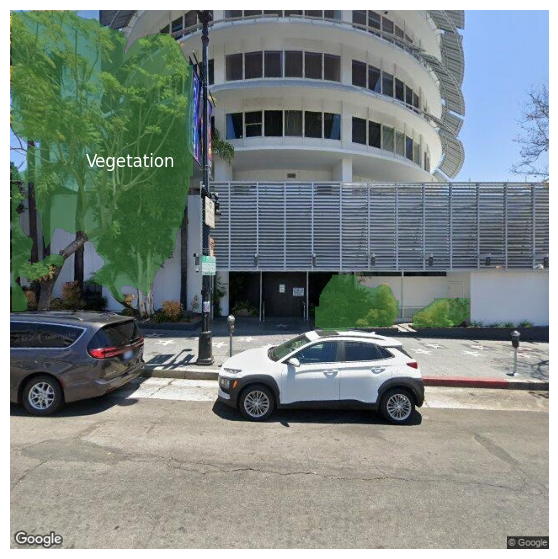

The GVI is 0.159970703125


In [2]:
from alivestreets.features.gvi_feature import GVIFeatureExtractor
from alivestreets.visualization.mask_visualization import TransparentMaskVisualizer


gvi_extractor = GVIFeatureExtractor()
#Download the pretrained model
gvi_extractor.download_model(os.path.join(os.getcwd(), "model_facades.pt"))

results = gvi_extractor.compute(img)
vegetation_mask = results["mask"]

mask_visualizer = TransparentMaskVisualizer()
mask_visualizer.visualize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), [vegetation_mask], ["Vegetation"], colors = ["#3E7D3E"])
print(f"The GVI is {results['GVI']}")



### Collecting pictures over and network and tagging vegetation

In this second part of the notebook i will illustrate how to:

<ol>
<li>Collect Street View Images over a whole street network</li>
<li>Tag the Green View Index at the different streets</li>
<ol>

Skipping field name: unsupported OGR type: 5


Exported: data/network_2.geojson


<Axes: >

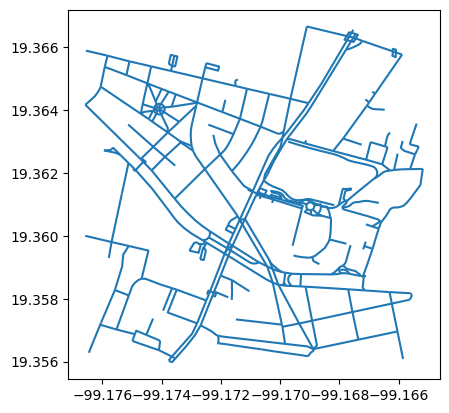

In [3]:
from alivestreets.network import network_retrieval, osm_features
from alivestreets.sampling.street_sampler import StreetSampler
import geopandas as gpd
import alivestreets as ast

lat = 19.36132786021484
lon = -99.17086000273748
radius = 600

graph = network_retrieval.get_graph_from_point(lat, lon, radius)
network_path = "data/network_2.geojson"
network_retrieval.export_graph_geojson(graph, network_path)

gdf = gpd.read_file(network_path)
gdf.plot()

The number of sampling points is 279


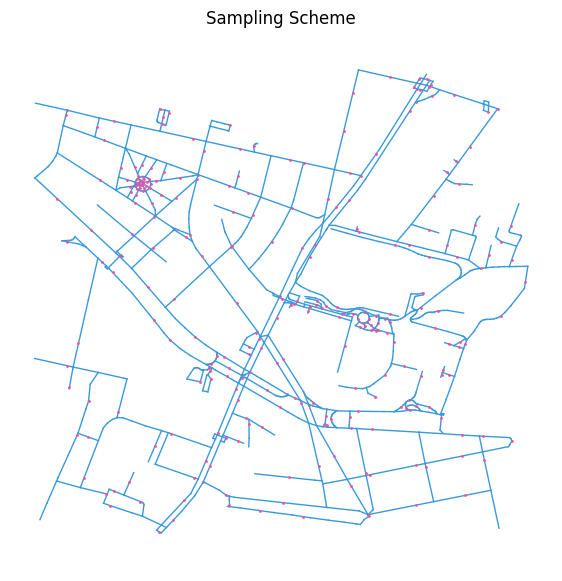

In [4]:
from alivestreets.sampling.street_sampler import StreetSampler

# Create a StreetSampler with a maximum number of sampling points
sampler = StreetSampler(max_points=200)

# Load the exported network
sampler.open_streets("data/network_2.geojson")

# Sample the streets
sampler.sample_streets_no_intersections()

# Optional: draw sampling scheme
sampler.draw_sampling_scheme(width=7, height=7, node_size = 1)

print(f"The number of sampling points is {len(sampler.get_all_sampling_points())}")

In [10]:
from alivestreets.streetview_collection.streetview_network_collection import StreetViewNetworkCollector

#In this case i will simply obtain the sidewalk views.
network_image_collector = StreetViewNetworkCollector(
    "sidewalks",
    api_key,

)

output_path_images = os.path.join(os.getcwd(), "data", "network_images_demo")


#point_dictionaries = network_image_collector.collect_street_sampler_images(
    #sampler,
    #output_path_images
#)


100%|██████████| 279/279 [06:12<00:00,  1.34s/it]


In [19]:
import json
from tqdm import tqdm
#Once you have obtained the images once you can load the point dictionary which by default is stored in the output_path
path_points_dictionary = os.path.join(output_path_images, "point_dictionaries.jsonl")
data = []

with open(path_points_dictionary, "r") as f:
    for line in f:
        data.append(json.loads(line))


#Ok let's obtain the mean GVI over all views

gvi_points = []
for i in tqdm(range(0,len(data))):
    point_dictionary = data[i]
    view_paths = point_dictionary["view_paths"]

    gvi = 0
    n_paths = len(view_paths)
    for j in range(0,len(view_paths)):
        img = cv2.imread(view_paths[j])
        results = gvi_extractor.compute(img)
        gvi += results["GVI"]/n_paths
    
    gvi_points.append(gvi)

100%|██████████| 279/279 [02:51<00:00,  1.62it/s]


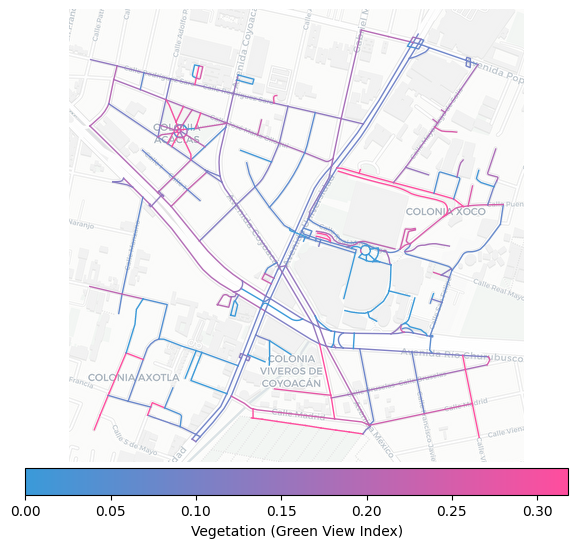

In [21]:
from alivestreets.visualization.map_visualizer import MapVisualizer

#Great, now you tag the GVI just like every other feature.
sampler.tag_streets(
    "GVI", 
    gvi_points,
    method = "mean"
)

vis = MapVisualizer()
vis.initialize_map(figsize = (7,7))

vis.add_street_sampler(sampler, 
"GVI", 
variable_type="continuous",
edge_width = 1)
vis.draw_networks(colorbar_label = "Vegetation (Green View Index)", colorbar_orientation = "horizontal")
vis.add_basemap(alpha = 0.7)
vis.finalize_map()



In [23]:
#If you want you can save the tagged streets as a geojson
from alivestreets.sampling.geojson_sampler_exporter import StreetSamplerGeojsonExporter

exporter = StreetSamplerGeojsonExporter(sampler)
exporter.export(os.path.join(os.getcwd(), "data", "vegetation_tagged.geojson"), default_method = "mean")

<Axes: >

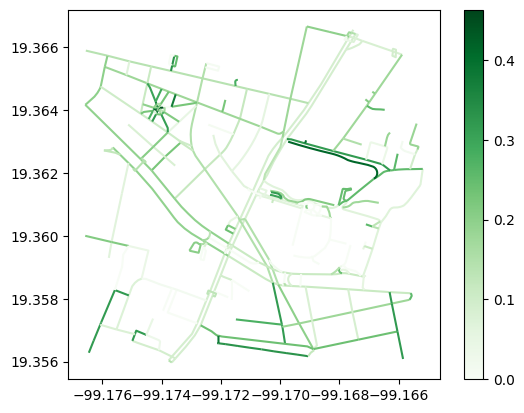

In [24]:
import geopandas as gpd

gdf = gpd.read_file(os.path.join(os.getcwd(), "data", "vegetation_tagged.geojson"))
gdf.plot(column="GVI", cmap="Greens", legend=True)